In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import pandas as pd
import numpy as np
%aimport AD_comparison_tools
%aimport AD_predictor_tools
%aimport ADpred_LambertTFs_helper
import protfasta
import matplotlib.pyplot as plt
import seaborn as sns
#import metapredict as meta
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

sns.set_theme(rc={'figure.figsize':(6,4), 'figure.dpi' : 300})
sns.set_style("white")
from parrot import py_predictor

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


# predictor outputs

In [4]:
human_predictor = py_predictor.Predictor("../output/parrot_lambert_tf_aggreg_preds_output", dtype = 'residues')

In [5]:
human_predictor_test_output = pd.read_csv("../output/parrot_lambert_tf_aggreg_preds_output_predictions.tsv",     
            header=None
)
human_predictor_test_output["uniprotID"] = human_predictor_test_output[0].str.split("_").str[0]
human_predictor_test_output["group"] = human_predictor_test_output[0].str.split("_").str[1].str.split(" ").str[0]
human_predictor_test_output["values"] = human_predictor_test_output[0].str.split(" ").str[2:]
human_predictor_test_output["values"] = human_predictor_test_output["values"].apply(lambda arr: [float(val) for val in arr])
human_predictor_test_output = human_predictor_test_output[human_predictor_test_output["group"] == "PRED"]
human_predictor_test_output

,0,uniprotID,group,values
1,P57073_PRED MLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPP...,P57073,PRED,"[0.020995677, 0.05383175, 0.032915153, 0.06038..."
3,P23759_PRED MAALPGTVPRMMRPAPGQNYPRTGFPLEVSTPLG...,P23759,PRED,"[-0.007915892, 0.0044425353, -0.0033784062, 0...."
5,Q9ULX6_PRED MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTW...,Q9ULX6,PRED,"[0.02124333, 0.026465729, 0.039964393, 0.03527..."
7,Q9Y2Y4_PRED MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLIT...,Q9Y2Y4,PRED,"[0.00011461228, 0.0004461184, 0.012523763, 0.0..."
9,P02788_PRED MKLVFLVLLFLGALGLCLAGRRRSVQWCAVSQPE...,P02788,PRED,"[-0.010699801, 0.004176393, 0.002047889, 0.021..."
...,...,...,...,...
473,Q8TD94_PRED MSAAVACLDYFAAECLVSMSAGAVVHRRPPDPEG...,Q8TD94,PRED,"[0.12078214, 0.13988836, 0.14560707, 0.1431540..."
475,A8MQ14_PRED MNMEGLVMFQDLSIDFSQEEWECLDAAQKDLYRD...,A8MQ14,PRED,"[0.5907577, 0.60170156, 0.5752578, 0.59915787,..."
477,Q8IYB9_PRED MELVTFRDVAIEFSPEEWKCLDPAQQNLYRDVML...,Q8IYB9,PRED,"[0.2840611, 0.27889422, 0.2630312, 0.2777081, ..."
479,P48742_PRED MVHCAGCKRPILDRFLLNVLDRAWHVKCVQCCEC...,P48742,PRED,"[0.0031030402, 0.020505667, 0.014487021, 0.016..."


In [6]:
human_predictor_test_output["positions"] = [np.arange(1, len(v) + 1) for v in human_predictor_test_output["values"]]
pred_positions = human_predictor_test_output.drop(columns = [0, 'group']).explode(["values", "positions"])
pred_positions

,uniprotID,values,positions
1,P57073,0.020996,1
1,P57073,0.053832,2
1,P57073,0.032915,3
1,P57073,0.060389,4
1,P57073,0.036155,5
...,...,...,...
481,Q9BSG1,0.070916,421
481,Q9BSG1,0.115388,422
481,Q9BSG1,0.109677,423
481,Q9BSG1,0.103251,424


# for each position, get whether it overlaps AD or not

In [7]:
known_ADs = pd.read_csv("../../SFARI/output/known_ADs_considering_isoforms_and_canonical_with_alerasool.csv", index_col = 0)
known_ADs = known_ADs[["uniprotID", "Start", "End"]]
known_ADs["positions"] = [np.arange(s, e) for s, e in zip(known_ADs["Start"], known_ADs["End"])]
known_ADs = known_ADs.drop(columns = ["Start", "End"])
known_ADs = known_ADs.explode("positions")
known_ADs = known_ADs.reset_index(drop=True)
known_ADs["AD"] = 1
known_ADs

,uniprotID,positions,AD
0,Q6UWZ7,121,1
1,Q6UWZ7,122,1
2,Q6UWZ7,123,1
3,Q6UWZ7,124,1
4,Q6UWZ7,125,1
...,...,...,...
90432,B2RXH4,535,1
90433,B2RXH4,536,1
90434,B2RXH4,537,1
90435,B2RXH4,538,1


In [8]:
preds_with_truth = pd.merge(pred_positions, known_ADs, how = 'left')
preds_with_truth["AD"] = preds_with_truth["AD"].fillna(0)
preds_with_truth

,uniprotID,values,positions,AD
0,P57073,0.020996,1,0.0
1,P57073,0.053832,2,0.0
2,P57073,0.032915,3,0.0
3,P57073,0.060389,4,0.0
4,P57073,0.036155,5,0.0
...,...,...,...,...
144186,Q9BSG1,0.070916,421,0.0
144187,Q9BSG1,0.115388,422,0.0
144188,Q9BSG1,0.109677,423,0.0
144189,Q9BSG1,0.103251,424,0.0


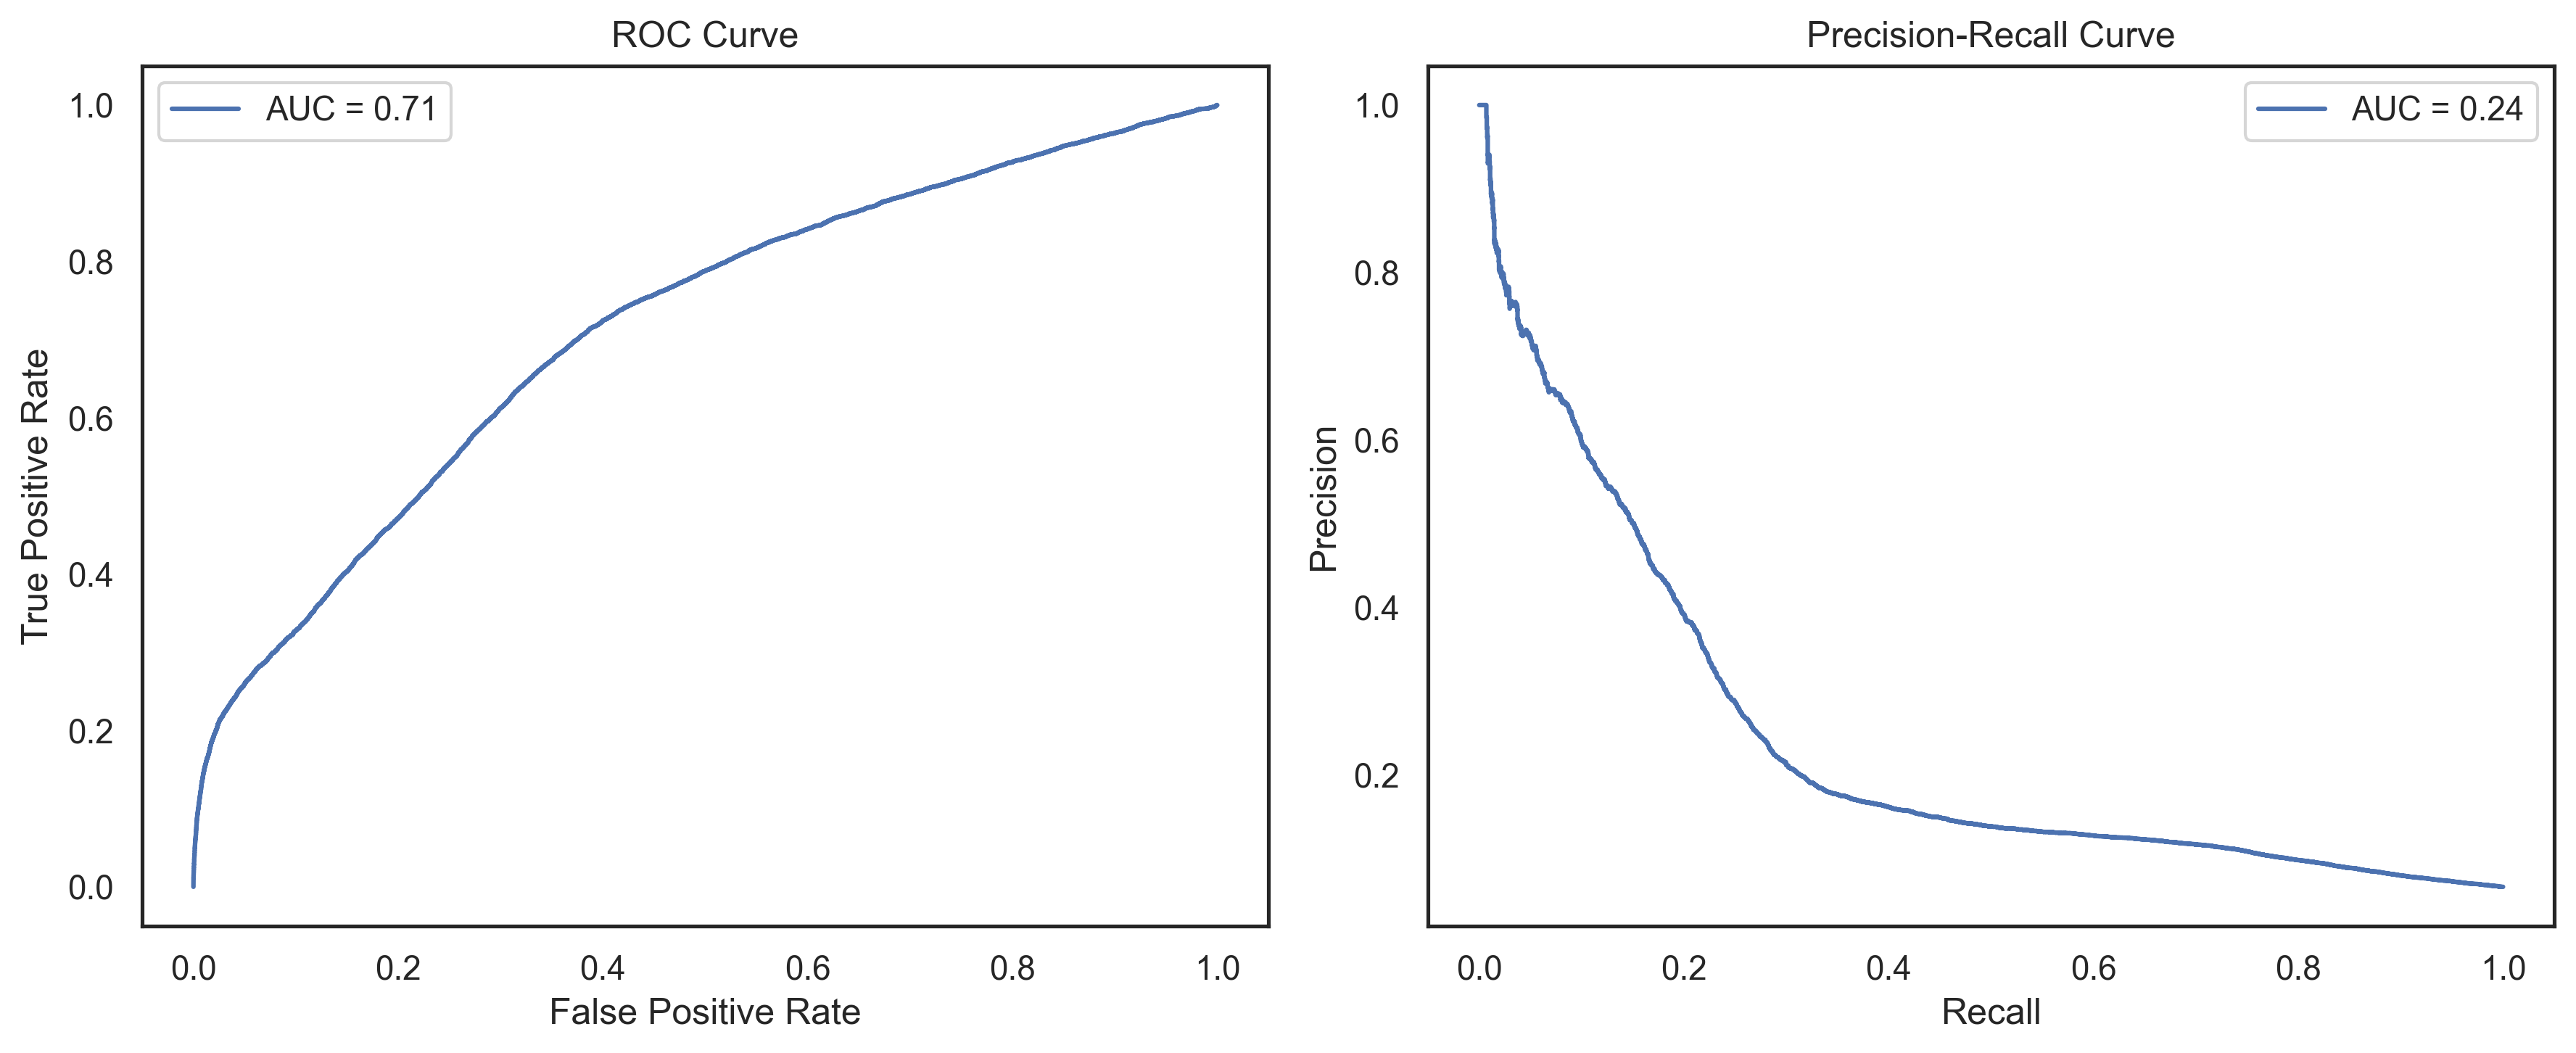

In [9]:
# ROC Curve
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
#plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
#plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Threshold (by max F1): 0.4039
F1 Score at Best Threshold: 0.2709


# compare to input

In [11]:
human_preds_input = pd.read_csv("../output/lambert_TF_aggreg_preds.tsv",     
            header=None
)
human_preds_input["uniprotID"] = human_preds_input[0].str.split(r"\t").str[0]
human_preds_input["values"] = human_preds_input[0].str.split(r"\t").str[2:]
human_preds_input["values"] = human_preds_input["values"].apply(lambda arr: [float(val) for val in arr if val != ""])
human_preds_input

,0,uniprotID,values
0,P23511\tMEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTE...,P23511,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Q96QS3\tMSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSP...,Q96QS3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,P31270\tMDFDERGPCSSNMYLPSCTYYVSGPDFSSLPSFLPQTP...,P31270,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3,P50221\tMDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHY...,P50221,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,P57073\tMLDMSEARSQPPCSPSGTASSMSHVEDSDSDAPPSPAG...,P57073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
1603,P35227\tMHRTTRIKITELNPHLMCALCGGYFIDATTIVECLHSF...,P35227,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1604,Q9BS34\tMDSVSFEDVAVAFTQEEWALLDPSQKNLYRDVMQEIFR...,Q9BS34,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
1605,P17098\tMDPEDEGVAGVMSVGPPAARLQEPVTFRDVAVDFTQEE...,P17098,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1606,Q9UJW7\tMETLTSRHEKRALHSQASAISQDREEKIMSQEPLSFKD...,Q9UJW7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
human_preds_input["positions"] = [np.arange(1, len(v) + 1) for v in human_preds_input["values"]]
input_positions = human_preds_input.drop(columns = [0]).explode(["values", "positions"])
input_positions

,uniprotID,values,positions
0,P23511,0.0,1
0,P23511,0.0,2
0,P23511,0.0,3
0,P23511,0.0,4
0,P23511,0.0,5
...,...,...,...
1607,Q9Y5X4,0.0,406
1607,Q9Y5X4,0.0,407
1607,Q9Y5X4,0.0,408
1607,Q9Y5X4,0.0,409


In [13]:
input_with_truth = pd.merge(input_positions, known_ADs, how = 'left')
input_with_truth["AD"] = input_with_truth["AD"].fillna(0)
input_with_truth

,uniprotID,values,positions,AD
0,P23511,0.0,1,1.0
1,P23511,0.0,2,1.0
2,P23511,0.0,3,1.0
3,P23511,0.0,4,1.0
4,P23511,0.0,5,1.0
...,...,...,...,...
942443,Q9Y5X4,0.0,406,0.0
942444,Q9Y5X4,0.0,407,0.0
942445,Q9Y5X4,0.0,408,0.0
942446,Q9Y5X4,0.0,409,0.0


In [14]:
TF_lim_input = input_with_truth[input_with_truth["uniprotID"].isin(preds_with_truth["uniprotID"])]
TF_lim_input

,uniprotID,values,positions,AD
1476,P57073,0.0,1,0.0
1477,P57073,0.0,2,0.0
1478,P57073,0.0,3,0.0
1479,P57073,0.0,4,0.0
1480,P57073,0.0,5,0.0
...,...,...,...,...
938585,Q9BSG1,0.0,421,0.0
938586,Q9BSG1,0.0,422,0.0
938587,Q9BSG1,0.0,423,0.0
938588,Q9BSG1,0.0,424,0.0


In [20]:
# Get thresholds from the precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])

# Calculate F1 score for each threshold
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_index = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_index]
best_f1 = f1_scores[best_index]

print(f"Best Input Threshold (by max F1): {best_threshold:.4f}")
print(f"F1 Score at Best Threshold: {best_f1:.4f}")

Best Input Threshold (by max F1): 0.6000
F1 Score at Best Threshold: 0.2785


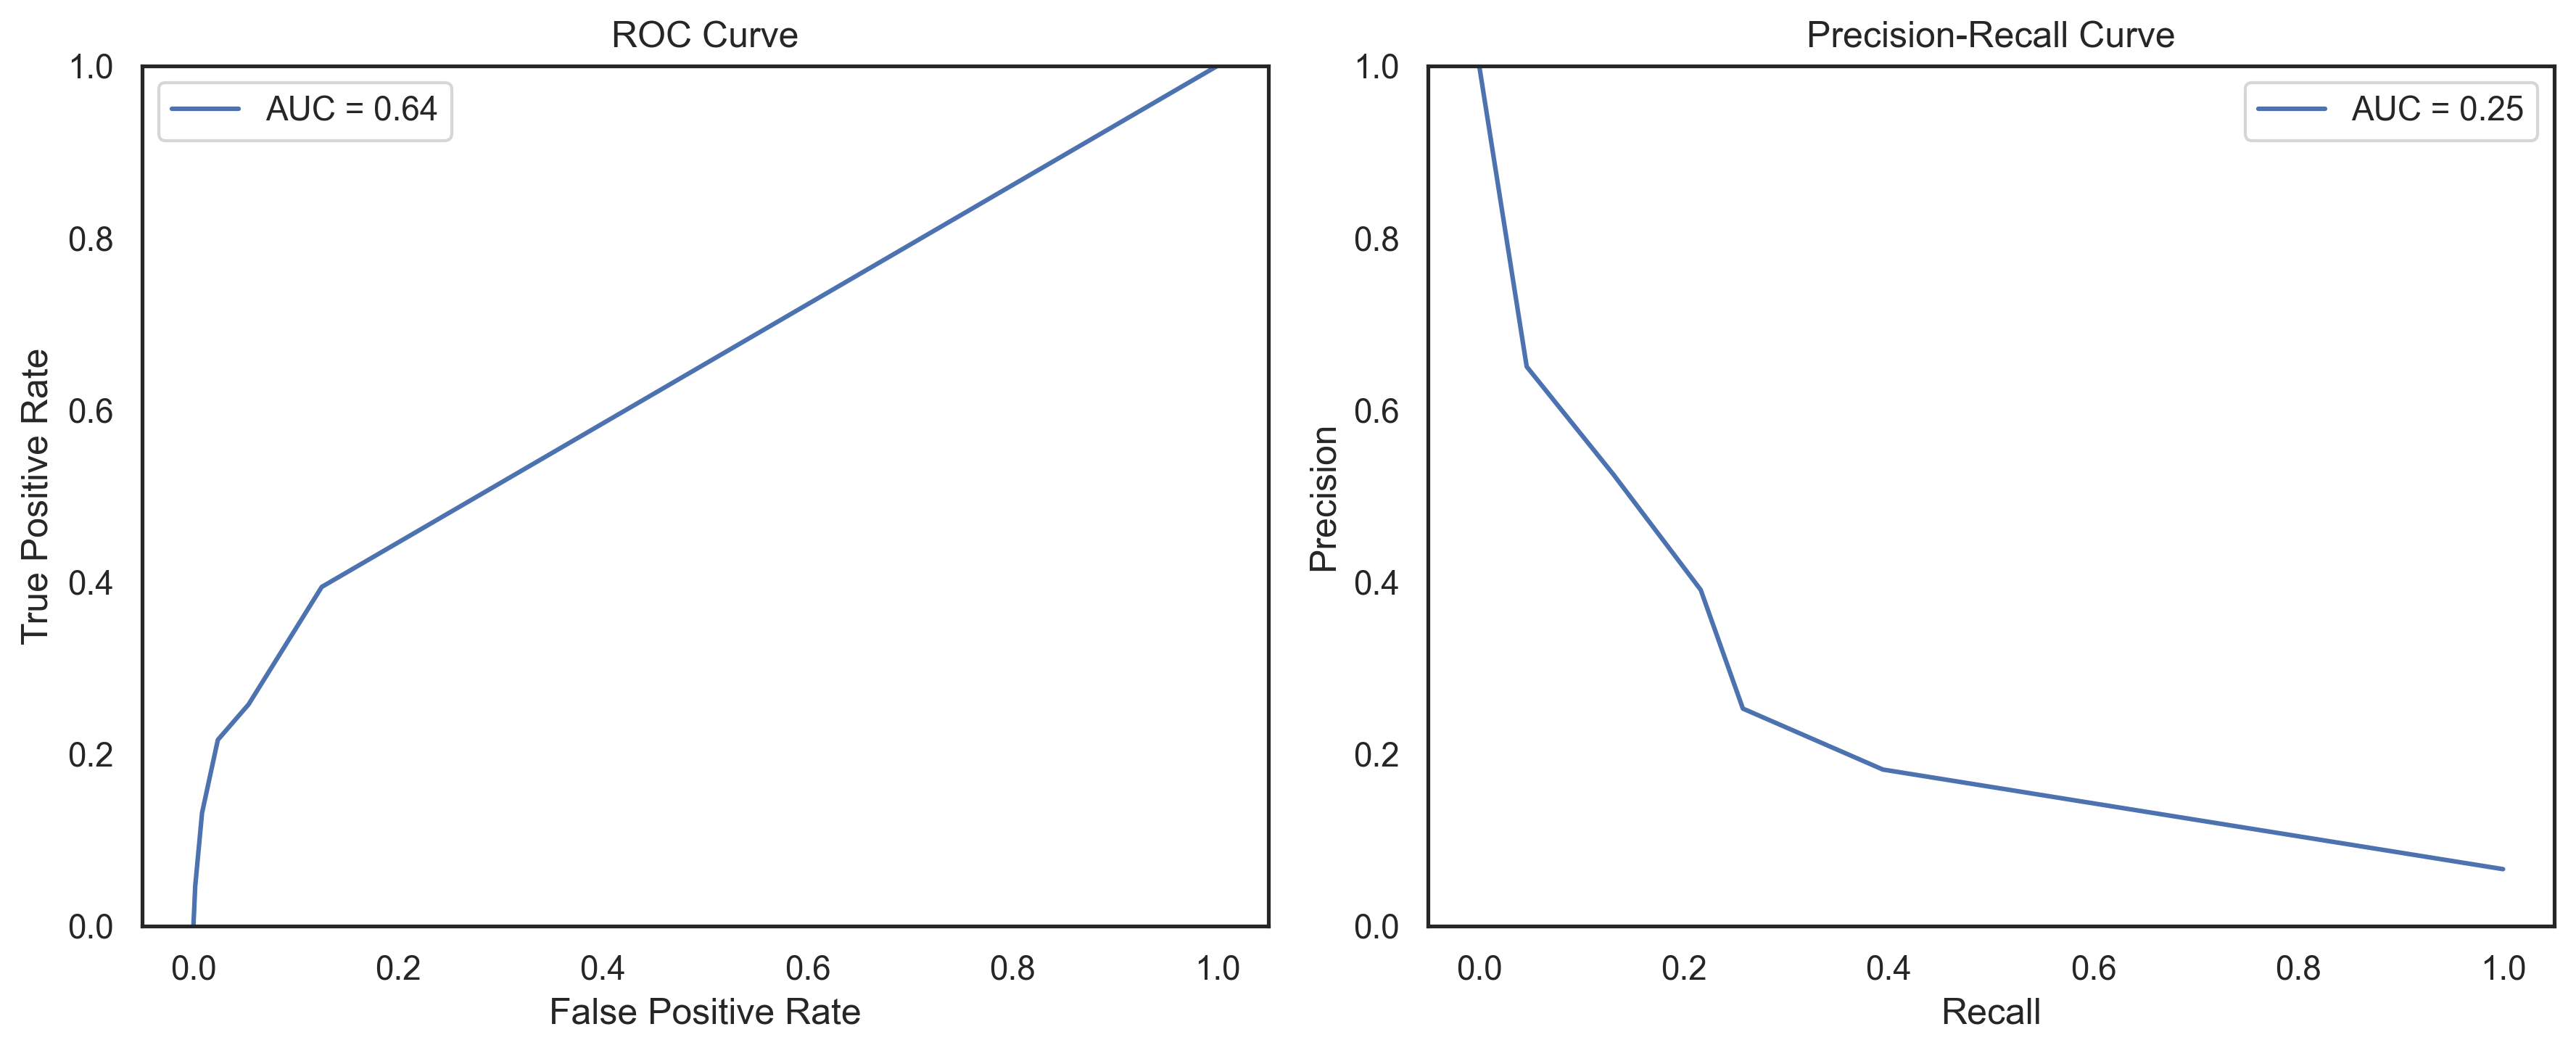

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


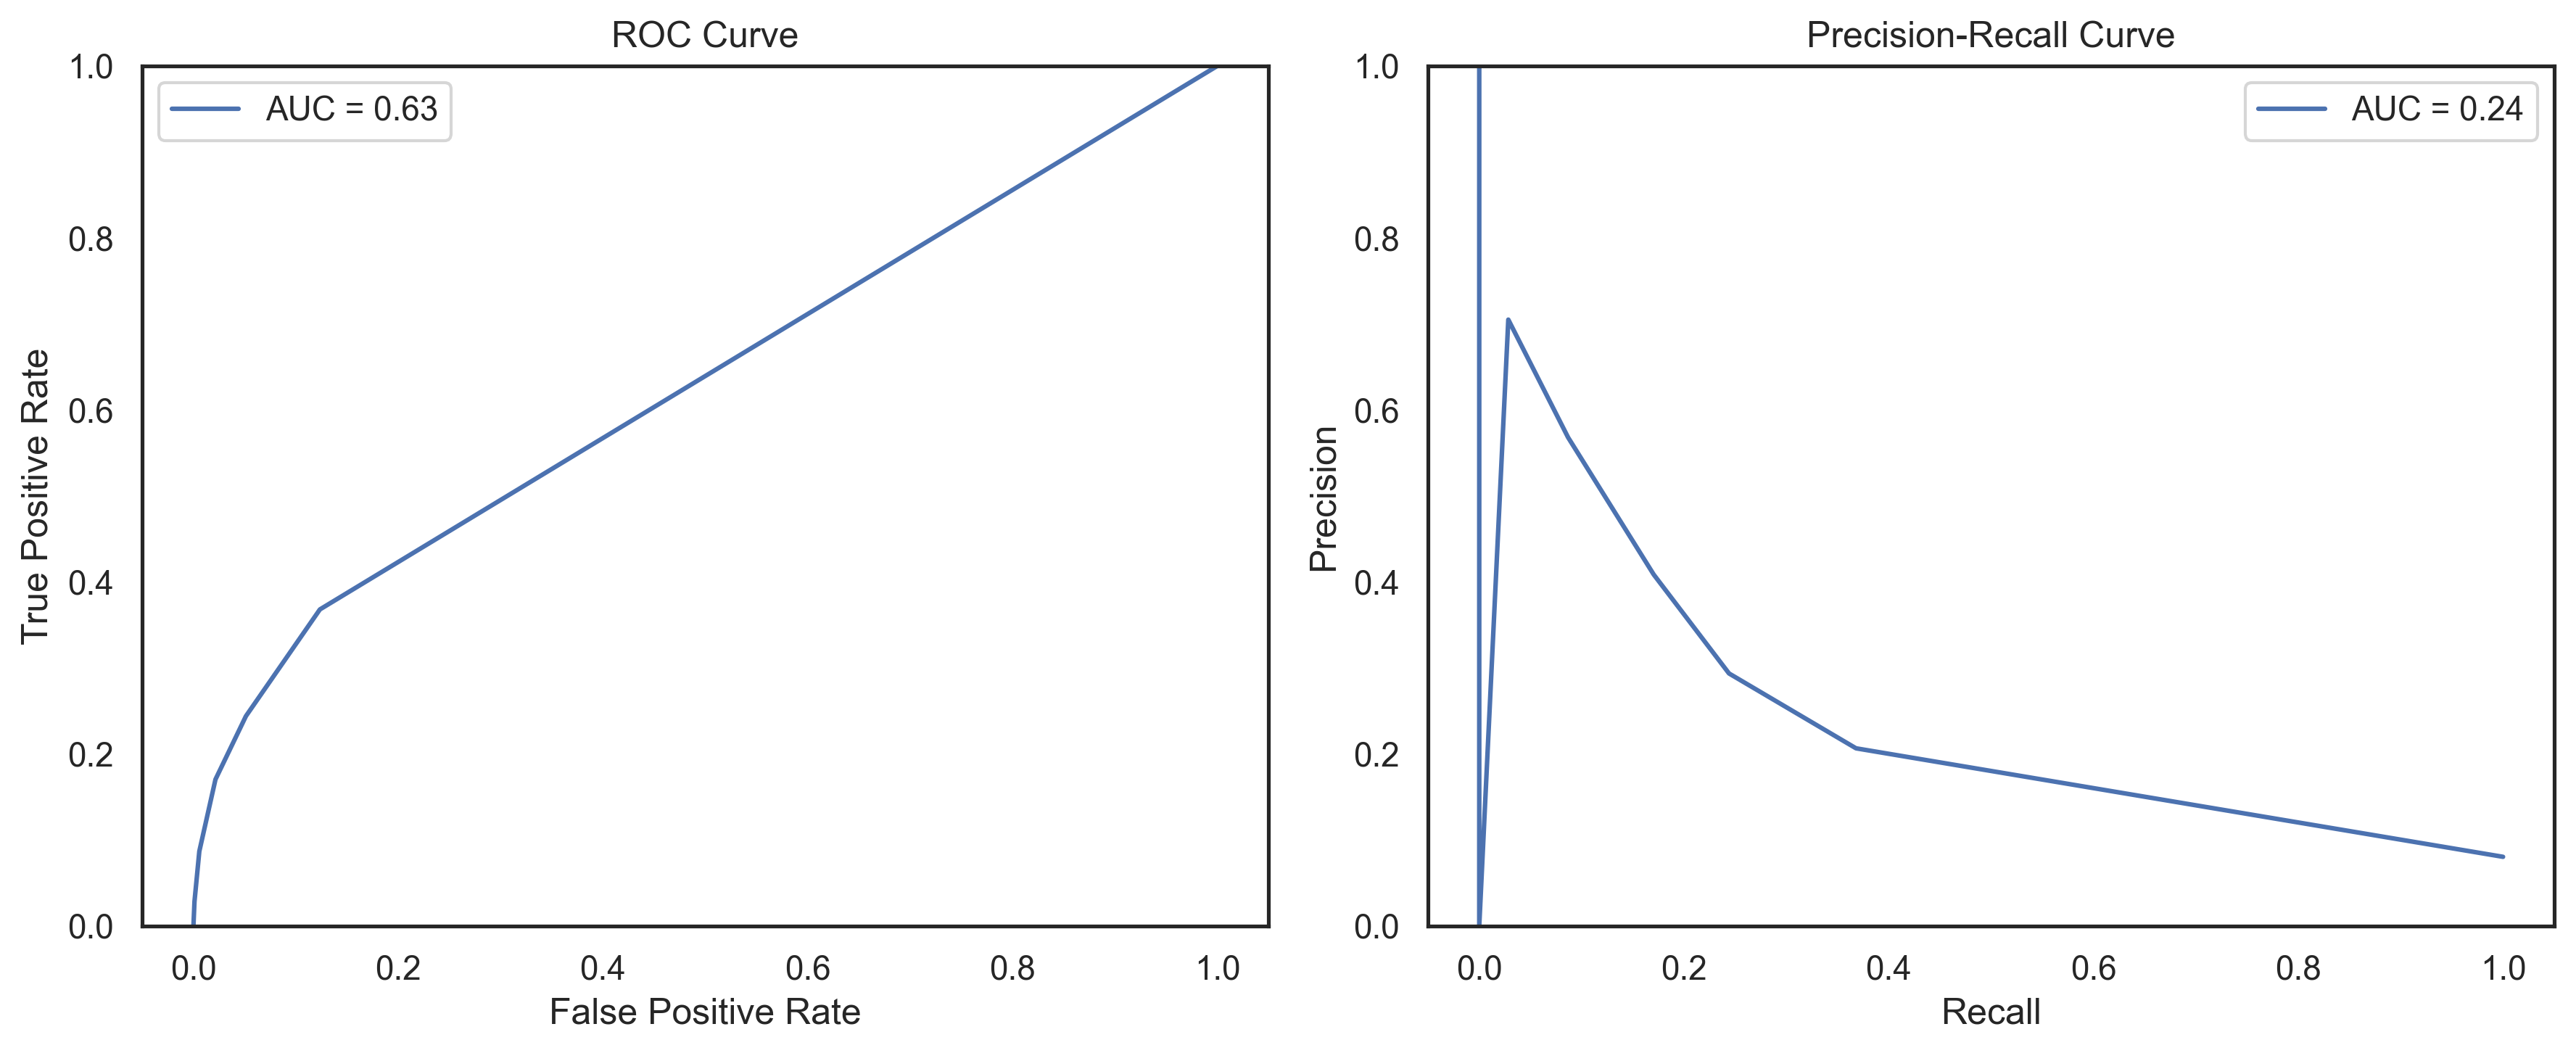

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(input_with_truth["AD"], input_with_truth["values"])
roc_auc = auc(fpr, tpr)

# PRC Curve
precision, recall, _ = precision_recall_curve(input_with_truth["AD"], input_with_truth["values"])
prc_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.ylim(0,1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AUC = {prc_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.ylim(0,1)
plt.legend()

plt.tight_layout()
plt.show()


Text(0.5, 1.1, 'PARROT Human TF-Trained Consensus:\nTest Human TFs')

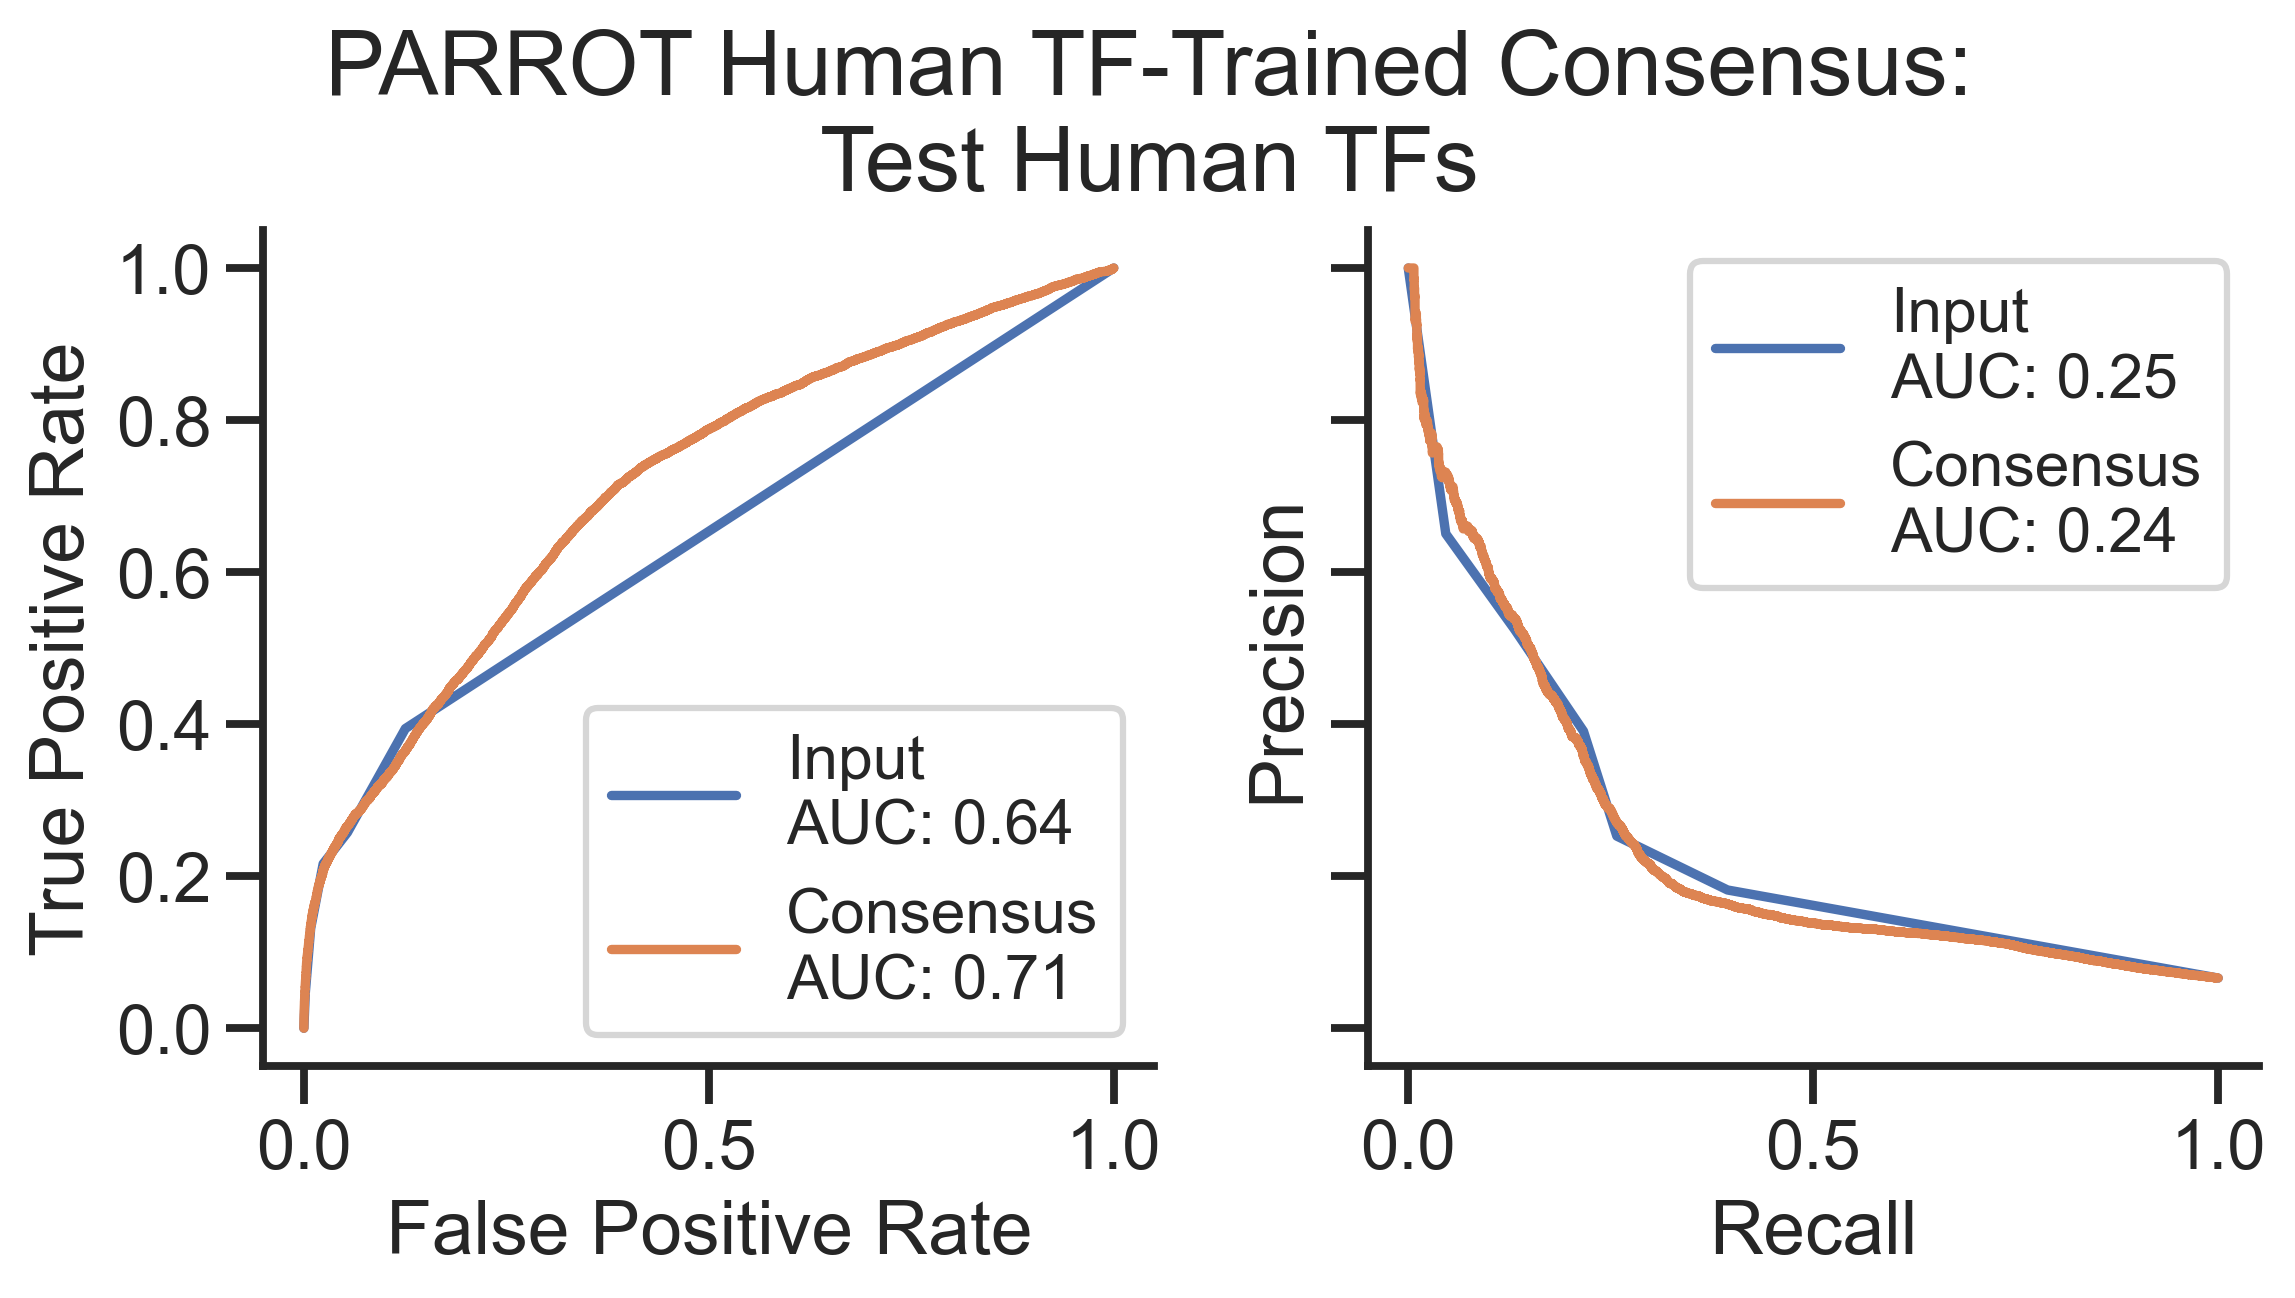

In [21]:
sns.set_context('talk')
sns.set_style('ticks')

    
fig, axs = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

## ROC
# Input
fpr, tpr, _ = roc_curve(TF_lim_input["AD"], TF_lim_input["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Input\nAUC: {roc_auc:.2f}")


# Preds
fpr, tpr, _ = roc_curve(preds_with_truth["AD"], preds_with_truth["values"])
roc_auc = auc(fpr, tpr)
axs[0].plot(fpr, tpr, label=f"Consensus\nAUC: {roc_auc:.2f}")


axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(fontsize = 'small')

## PRC

# Input
precision, recall, _ = precision_recall_curve(TF_lim_input["AD"], TF_lim_input["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Input\nAUC: {prc_auc:.2f}")

# Preds
precision, recall, _ = precision_recall_curve(preds_with_truth["AD"], preds_with_truth["values"])
prc_auc = auc(recall, precision)

axs[1].plot(recall, precision, label=f"Consensus\nAUC: {prc_auc:.2f}")
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")

axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(fontsize = 'small')

sns.despine()
plt.tight_layout()

plt.suptitle("PARROT Human TF-Trained Consensus:\nTest Human TFs", y = 1.1)